In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

import time
import json

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


%load_ext autotime 
#pip install ipython-autotime

time: 0 ns (started: 2023-03-28 16:28:25 +03:00)


In [2]:
# Lakes and DWTP of EYDAP
LAKES = ['EVINOS','MARATHONAS','MORNOS','YLIKI']
MEN = ['ASPROPYRGOS','GALATSI','KIOURKA','MENIDI']

time: 0 ns (started: 2023-03-28 16:28:25 +03:00)


In [3]:
# Import Dataset

data = pd.read_csv('data.csv',decimal='.')

time: 63 ms (started: 2023-03-28 16:28:25 +03:00)


In [4]:
# Take a sample -n- 
# data = data.sample(n=2000)

time: 0 ns (started: 2023-03-28 16:28:25 +03:00)


# Data Cleaning

In [5]:
data = data.replace(',','', regex=True)

time: 141 ms (started: 2023-03-28 16:28:25 +03:00)


In [6]:
data.iloc[:,1:11] = data.iloc[:,1:11].astype(str).astype(float)

time: 31 ms (started: 2023-03-28 16:28:25 +03:00)


In [7]:
data.iloc[:,2:11] = data.iloc[:,2:11].replace(',','', regex=True)

time: 0 ns (started: 2023-03-28 16:28:25 +03:00)


In [8]:
data.DATE = pd.to_datetime(data.DATE,dayfirst=True)

time: 484 ms (started: 2023-03-28 16:28:25 +03:00)


In [9]:
data.TIME = data.TIME.str.split(':')
data.TIME = data.TIME.str[0]

time: 47 ms (started: 2023-03-28 16:28:26 +03:00)


In [10]:
data['TIME.1'] = data['TIME.1'].str.split(':')
data['TIME.1'] = data['TIME.1'].str[0]

time: 15 ms (started: 2023-03-28 16:28:26 +03:00)


In [11]:
data['TIME.2'] = data['TIME.2'].str.split(':')
data['TIME.2'] = data['TIME.2'].str[0]

time: 16 ms (started: 2023-03-28 16:28:26 +03:00)


In [12]:
data['TIME'] = data['TIME'].astype(float)
data['TIME.1'] = data['TIME.1'].astype(float)
data['TIME.2'] = data['TIME.2'].astype(float)

time: 0 ns (started: 2023-03-28 16:28:26 +03:00)


In [13]:
pd.set_option('display.max_columns', None)

time: 0 ns (started: 2023-03-28 16:28:26 +03:00)


In [14]:
data = data.rename(columns = {'HIGH':'HIGH_TEMP',
                               'TIME':'HIGH_TEMP_TIME',
                               'TIME.1':'LOW_TEMP_TIME',
                               'SPEED':'WIND_SPEED',
                               'HIGH.1':'WIND_HIGH_SPEED',
                               'TIME.2':'WIND_HIGH_SPEED_TIME',
                               'DAYS':'HEAT_DEG_DAYS',
                             'DAYS.1':'COOL_DEG_DAYS',
                             'LOW':'LOW_TEMP'})

time: 16 ms (started: 2023-03-28 16:28:26 +03:00)


E:\Program Files\bootcamp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


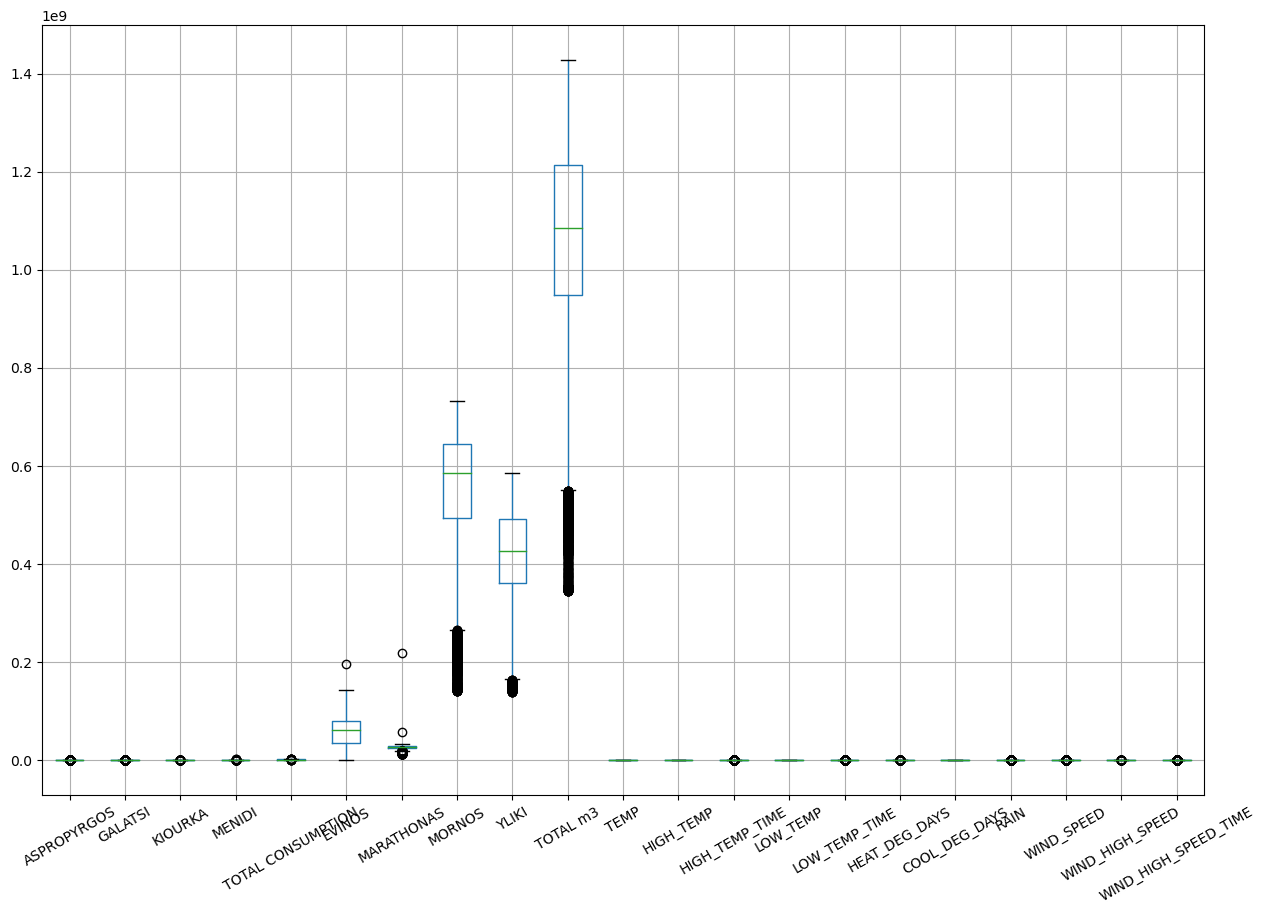

time: 1.11 s (started: 2023-03-28 16:28:26 +03:00)


In [15]:
# See outliers
boxplot = data.boxplot(figsize=(15,10))
boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=30)
None

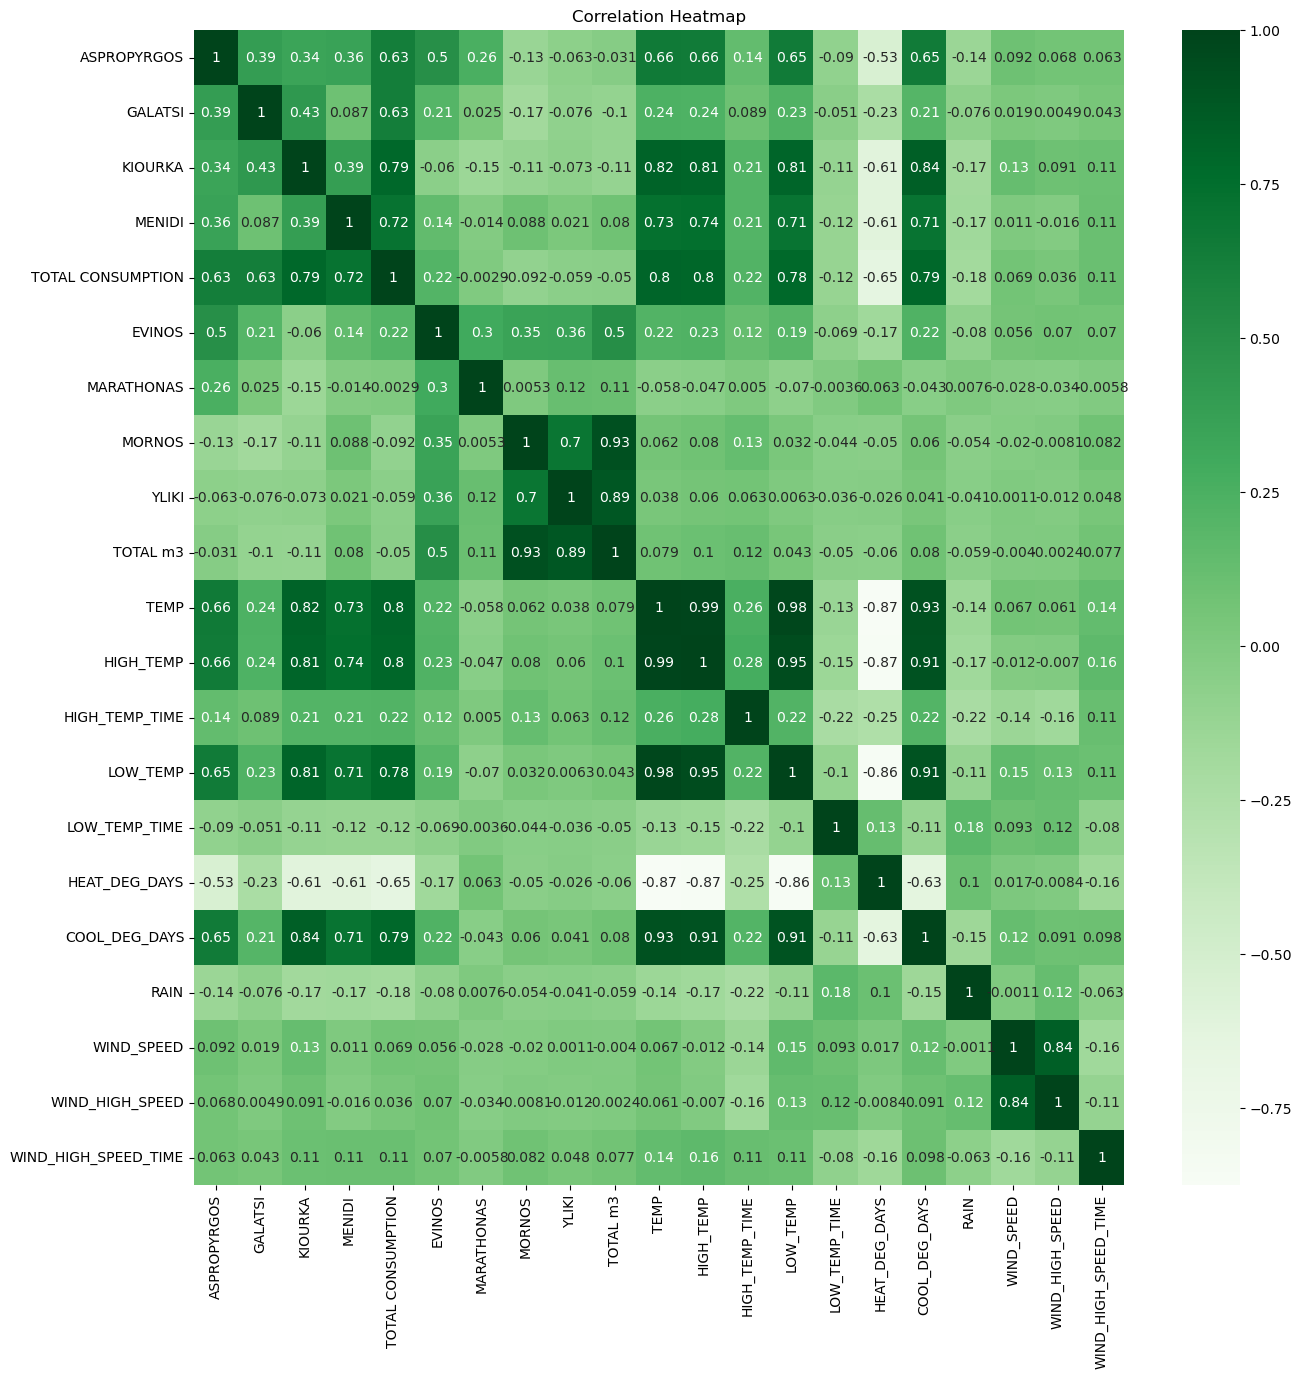

time: 1.39 s (started: 2023-03-28 16:28:27 +03:00)


In [16]:
# Sea the correlation heatmap
plt.figure(figsize = (15,15))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(data.corr(), annot = True, cmap="Greens")
plt.show()

In [17]:
# Delete features that have no correlation
DATA = data.loc[:, data.columns.drop(['TOTAL m3','WIND_HIGH_SPEED'])]
DATA.drop('WIND_SPEED',axis=1,inplace=True)
DATA.drop('WIND_HIGH_SPEED_TIME',axis=1,inplace=True)

time: 0 ns (started: 2023-03-28 16:28:28 +03:00)


In [18]:
# Delete features of MEN and LAKES. Lakes do not correlate with Attika Consumption. We drop out MEN as we have total consumption
DATA.drop(columns=MEN,inplace=True)
DATA.drop(columns=LAKES,inplace=True)

time: 16 ms (started: 2023-03-28 16:28:28 +03:00)


In [19]:
# Finally we drop NaNs
DATA = DATA.dropna()

time: 15 ms (started: 2023-03-28 16:28:28 +03:00)


In [20]:
print(f'Statistics for Rain: Min = {DATA.RAIN.min()} mm, Max = {DATA.RAIN.max()} mm, Median = {DATA.RAIN.median()} mm, Mean = {DATA.RAIN.mean()} mm')

Statistics for Rain: Min = 0.0 mm, Max = 97.0 mm, Median = 0.0 mm, Mean = 1.1884096522895689 mm
time: 0 ns (started: 2023-03-28 16:28:28 +03:00)


The outcome we want is a prediction per month. That is why we have to groupby month per year

In [21]:
#DATA.info()

time: 16 ms (started: 2023-03-28 16:28:28 +03:00)


In [22]:
# Rain is not high correlated with Total consumption. To increase the correlation we create a new feature of RAIN.
# If RAIN is more than the median of rain, then 1 else 0. This increaces the correlation from -0.18 to -0.31.
RAIN_COND = DATA.RAIN.apply(lambda x: 1 if x>2*DATA.RAIN.median() else 0)

time: 750 ms (started: 2023-03-28 16:28:28 +03:00)


In [23]:
DATA['RAIN_COND'] = RAIN_COND.values

time: 0 ns (started: 2023-03-28 16:28:29 +03:00)


In [24]:
# RAIN feature is deleted eventually
DATA.drop('RAIN',axis=1,inplace=True)

time: 16 ms (started: 2023-03-28 16:28:29 +03:00)


In [25]:
# Time of low temperatures are not correlated. 
#DATA.drop('LOW_TEMP_TIME',axis=1,inplace=True)

time: 0 ns (started: 2023-03-28 16:28:29 +03:00)


<Figure size 640x480 with 0 Axes>

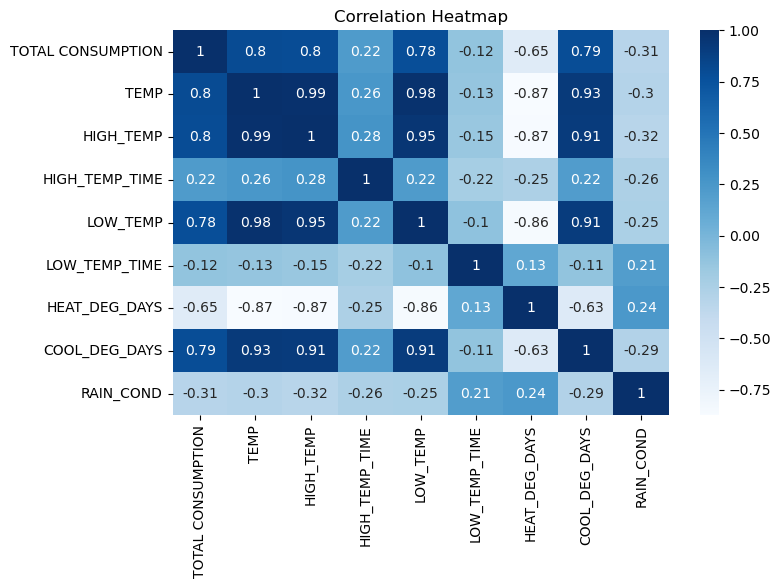

time: 375 ms (started: 2023-03-28 16:28:29 +03:00)


In [26]:
plt.clf()
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA.corr(), annot = True, cmap="Blues")
plt.show()

In [27]:
#Insert a new file. "Savings and repos" vs Year and Month* --> dianeosis.gr
repos = pd.read_csv('chart_repos.csv')

time: 0 ns (started: 2023-03-28 16:28:30 +03:00)


In [28]:
# Below code is for joining DATA with the previous file
repos['Μήνας']=repos['Μήνας'].str.split(' ')

time: 16 ms (started: 2023-03-28 16:28:30 +03:00)


In [29]:
repos['Month'] = repos['Μήνας'].str[0]
repos['Year'] = repos['Μήνας'].str[1]

time: 0 ns (started: 2023-03-28 16:28:30 +03:00)


In [30]:
repos['Year'] = repos['Year'].astype(int)

time: 0 ns (started: 2023-03-28 16:28:30 +03:00)


In [31]:
repos.drop('Μήνας',axis=1,inplace=True)

time: 16 ms (started: 2023-03-28 16:28:30 +03:00)


In [32]:
m = {'Iανουάριος':1,
     'Ιανούαριος':1,
     'Ιανουάριος':1,
    'Φεβρουάριος':2,
    'Μάρτιος':3,
    'Απρίλιος':4,
    'Μάιος':5,
    'Ιούνιος':6,
    'Ιούλιος':7,
    'Αύγουστος':8,
    'Σεπτέμβριος':9,
    'Οκτώβριος':10,
    'Νοέμβριος':11,
    'Δεκέμβριος':12}

time: 16 ms (started: 2023-03-28 16:28:30 +03:00)


In [33]:
repos.replace({'Month':m},inplace=True)

time: 15 ms (started: 2023-03-28 16:28:30 +03:00)


In [34]:
DATA['Month'] = DATA['DATE'].dt.month
DATA['Year'] = DATA['DATE'].dt.year

time: 0 ns (started: 2023-03-28 16:28:30 +03:00)


In [35]:
DATA_2 = DATA.merge(repos, on=['Month', 'Year'], how='inner')

time: 0 ns (started: 2023-03-28 16:28:30 +03:00)


In [36]:
DATA_2.drop('Month',axis=1,inplace=True)
DATA_2.drop('Year',axis=1,inplace=True)

time: 16 ms (started: 2023-03-28 16:28:30 +03:00)


<Figure size 640x480 with 0 Axes>

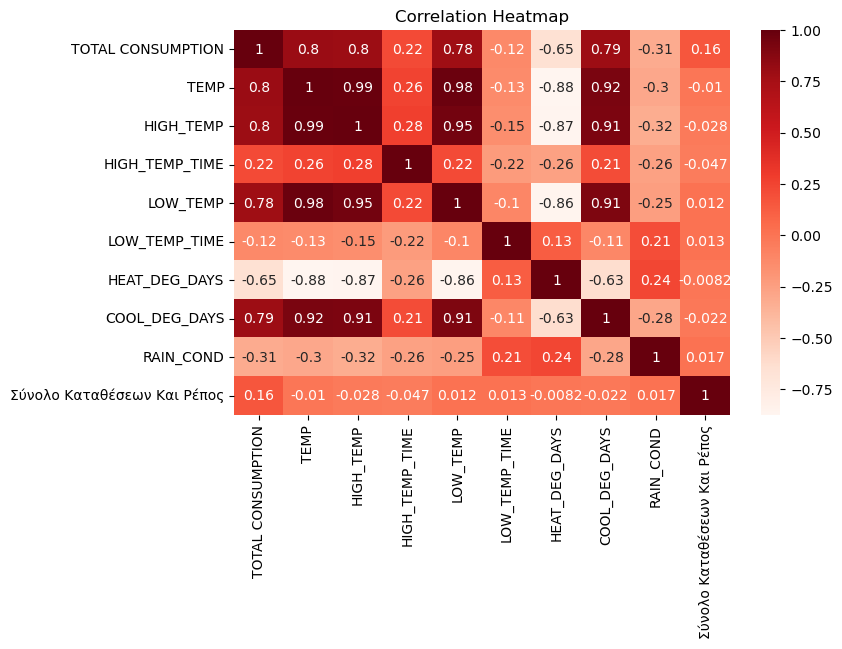

time: 421 ms (started: 2023-03-28 16:28:30 +03:00)


In [37]:
plt.clf()
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_2.corr(), annot = True, cmap="Reds")
plt.show()

Savings and Repos have low correlation with consumption. This is because the water cost per m3 is low and the country is prosperous enough.

In [38]:
# Insert a new file. "Revised KPI of industrial production" vs Year and Month* --> dianeosis.gr
industrial_KPI = pd.read_csv('chart_industrial_KPI.csv')
industrial_KPI['Μήνας'] = industrial_KPI['Μήνας'].str.split(' ')
industrial_KPI['Month'] = industrial_KPI['Μήνας'].str[0]
industrial_KPI['Year'] = industrial_KPI['Μήνας'].str[1]
industrial_KPI['Year'] = industrial_KPI['Year'].astype(int)
industrial_KPI.drop('Μήνας',axis=1,inplace=True)
industrial_KPI.replace({'Month':m},inplace=True)

DATA_2['Month'] = DATA_2['DATE'].dt.month
DATA_2['Year'] = DATA_2['DATE'].dt.year
DATA_3 = DATA_2.merge(industrial_KPI, on=['Month', 'Year'], how='inner')
DATA_3.drop('Month',axis=1,inplace=True)
DATA_3.drop('Year',axis=1,inplace=True)

time: 16 ms (started: 2023-03-28 16:28:30 +03:00)


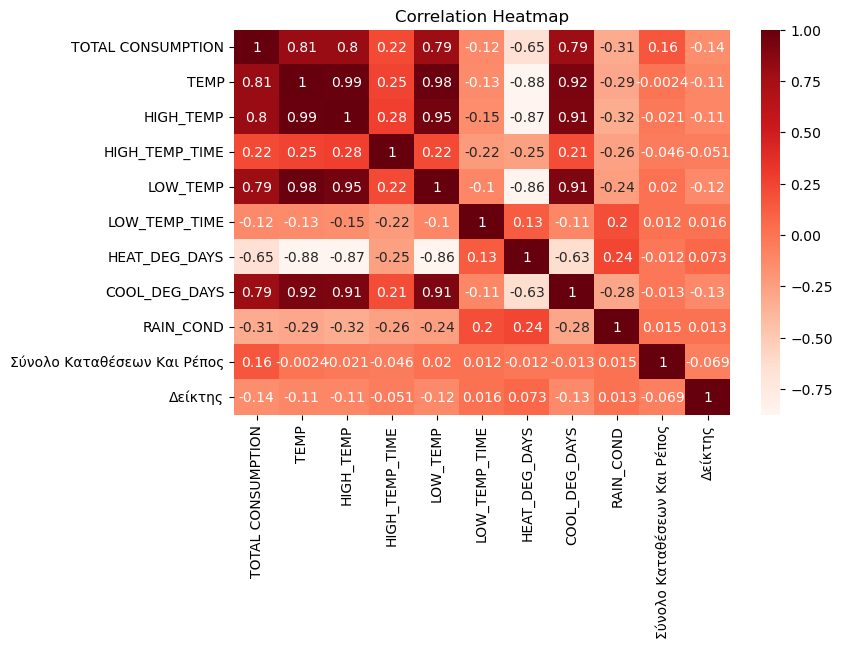

time: 422 ms (started: 2023-03-28 16:28:30 +03:00)


In [39]:
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_3.corr(), annot = True, cmap="Reds")

Industrial KPI has low correlation with consumption. This is because the water cost per m3 is low and the country is prosperous enough.

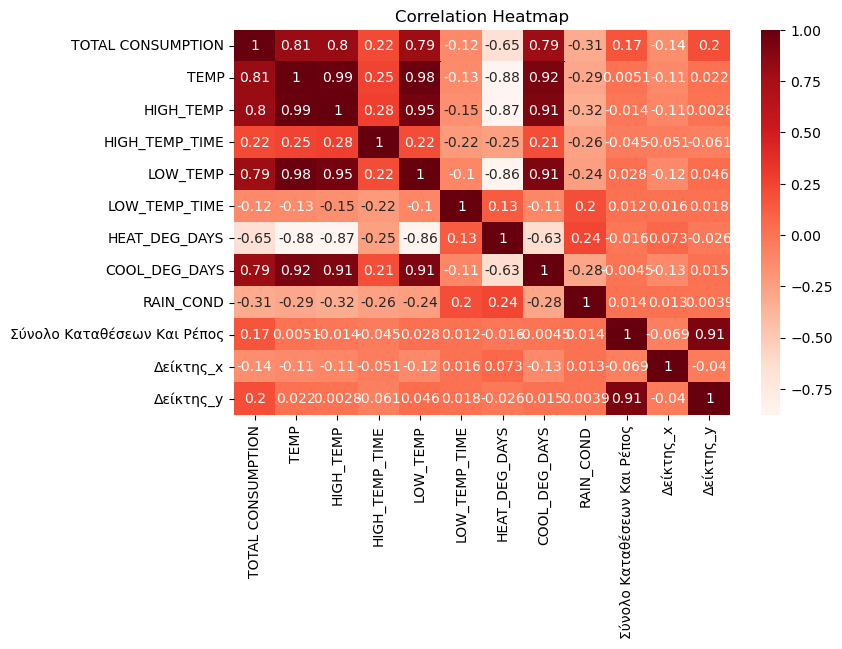

time: 485 ms (started: 2023-03-28 16:28:31 +03:00)


In [40]:
# Insert a new file. "KPI of retail circle" vs Year and Month* --> dianeosis.gr
retail_KPI = pd.read_csv('chart_retail_KPI.csv')
retail_KPI['Μήνας'] = retail_KPI['Mήνας'].str.split(' ')
retail_KPI['Month'] = retail_KPI['Μήνας'].str[0]
retail_KPI['Year'] = retail_KPI['Μήνας'].str[1]
retail_KPI['Year'] = retail_KPI['Year'].astype(int)
retail_KPI.drop('Μήνας',axis=1,inplace=True)
retail_KPI.replace({'Month':m},inplace=True)

DATA_3['Month'] = DATA_3['DATE'].dt.month
DATA_3['Year'] = DATA_3['DATE'].dt.year
DATA_4 = DATA_3.merge(retail_KPI, on=['Month', 'Year'], how='inner')
DATA_4.drop('Month',axis=1,inplace=True)
DATA_4.drop('Year',axis=1,inplace=True)

plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_4.corr(), annot = True, cmap="Reds")

Retail KPI has low correlation with consumption. This is because the water cost per m3 is low and the country is prosperous enough.

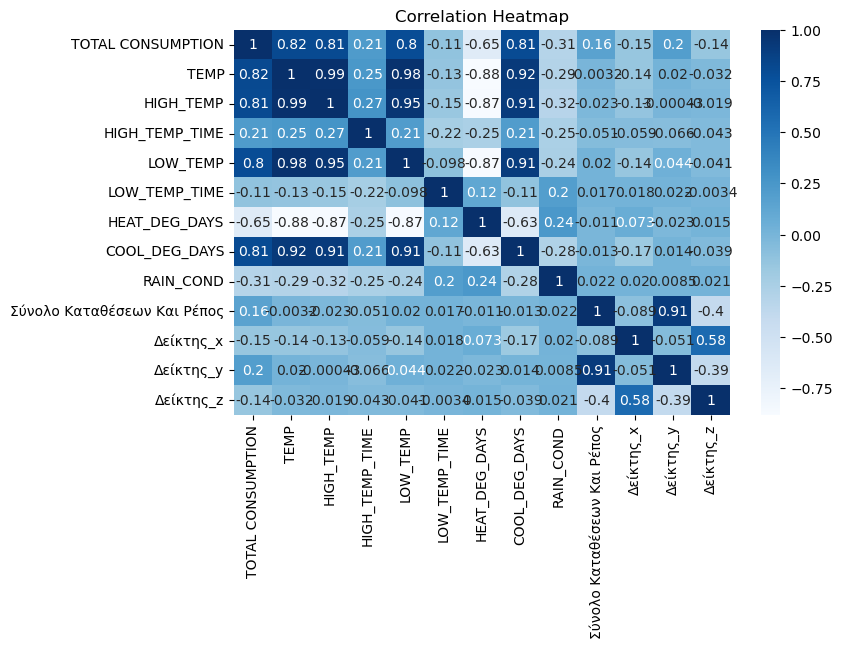

time: 562 ms (started: 2023-03-28 16:28:31 +03:00)


In [41]:
#chart_financial_KPI
financial_KPI = pd.read_csv('chart_financial_KPI.csv')
financial_KPI.drop('Ε.Ε-27',axis=1,inplace=True)
financial_KPI['Μήνας'] = financial_KPI['Μήνας'].str.split(' ')
financial_KPI['Month'] = financial_KPI['Μήνας'].str[0]
financial_KPI['Year'] = financial_KPI['Μήνας'].str[1]
financial_KPI['Year'] = financial_KPI['Year'].astype(int)
financial_KPI.drop('Μήνας',axis=1,inplace=True)
financial_KPI.replace({'Month':m},inplace=True)

DATA_4['Month'] = DATA_4['DATE'].dt.month
DATA_4['Year'] = DATA_4['DATE'].dt.year
DATA_5 = DATA_4.merge(financial_KPI, on=['Month', 'Year'], how='inner')
DATA_5.drop('Month',axis=1,inplace=True)
DATA_5.drop('Year',axis=1,inplace=True)
DATA_5.rename(columns={'Ελλάδα':'Δείκτης_z'},inplace=True)

plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_5.corr(), annot = True, cmap="Blues")

In [42]:
# Delete features that are not correlated, such as KPIs. 
DATA_5.drop('Δείκτης_x',axis=1,inplace=True)
DATA_5.drop('Δείκτης_y',axis=1,inplace=True)
DATA_5.drop('Δείκτης_z',axis=1,inplace=True)
DATA_5.drop('Σύνολο Καταθέσεων Και Ρέπος',axis=1,inplace=True)

time: 1.59 s (started: 2023-03-28 16:28:32 +03:00)


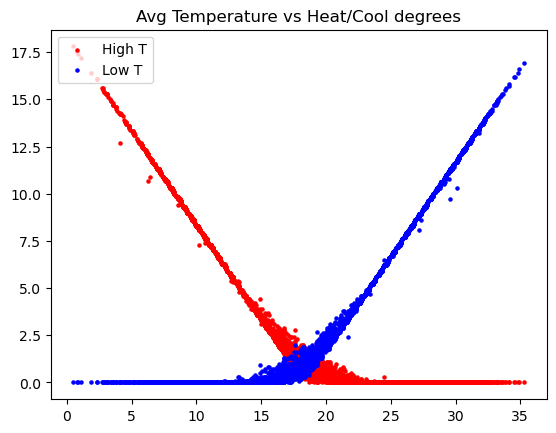

time: 125 ms (started: 2023-03-28 16:28:33 +03:00)


In [43]:
plt.clf()
plt.scatter(DATA_5['TEMP'],DATA_5['HEAT_DEG_DAYS'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['TEMP'],DATA_5['COOL_DEG_DAYS'],c=('BLUE'),label='Low T',s=5)
plt.title('Avg Temperature vs Heat/Cool degrees')
plt.legend(loc=2)
plt.show()

In [44]:
# Delete deg_days as are highly correlated with Temp, thus these features are redundant 
DATA_5.drop('HEAT_DEG_DAYS',axis=1,inplace=True)
DATA_5.drop('COOL_DEG_DAYS',axis=1,inplace=True)

time: 16 ms (started: 2023-03-28 16:28:33 +03:00)


<Figure size 640x480 with 0 Axes>

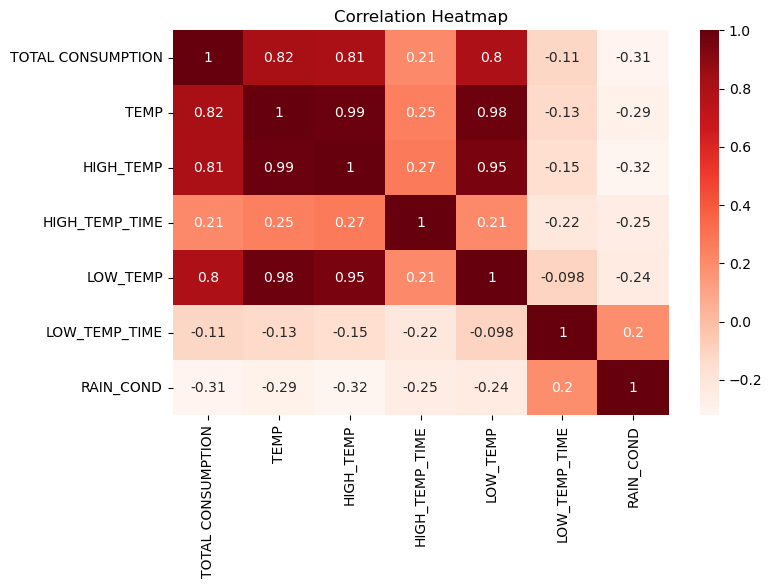

time: 265 ms (started: 2023-03-28 16:28:33 +03:00)


In [45]:
plt.clf()
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_5.corr(), annot = True, cmap="Reds")
plt.show()

High & Low Temperature times are to be investigated for their correlation

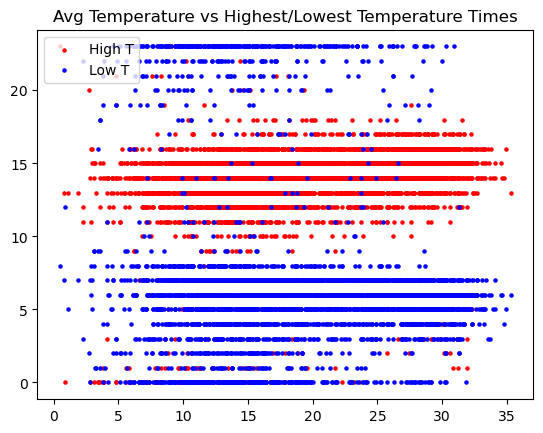

time: 187 ms (started: 2023-03-28 16:28:34 +03:00)


In [46]:
plt.clf()
plt.scatter(DATA_5['TEMP'],DATA_5['HIGH_TEMP_TIME'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['TEMP'],DATA_5['LOW_TEMP_TIME'],c=('BLUE'),label='Low T',s=5)
plt.title('Avg Temperature vs Highest/Lowest Temperature Times')
plt.legend(loc=2)
plt.show()

It is clear from the upper diagram that highest temperature are mainly between 10:00 - 17:00. 

Text(0.5, 0, 'CONSUMPTION')

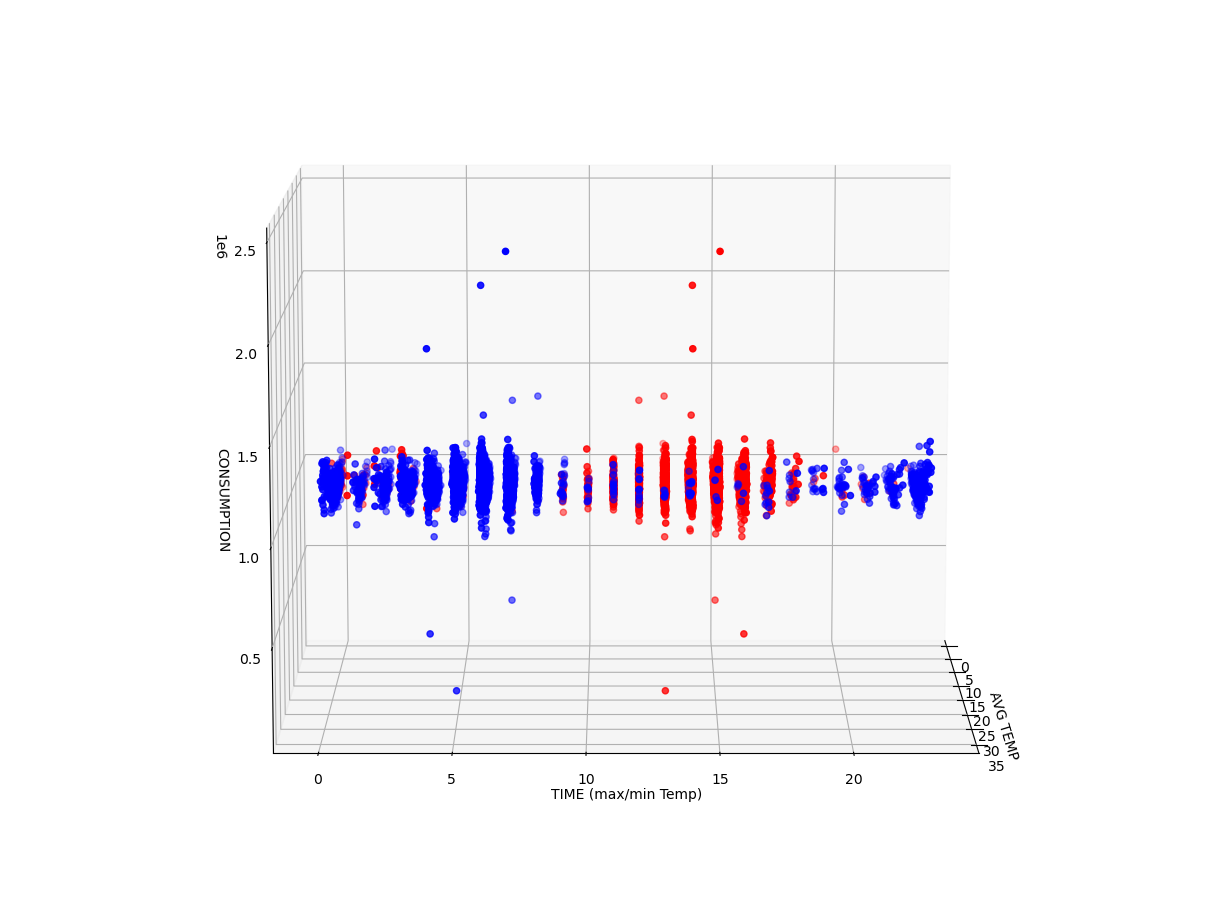

time: 359 ms (started: 2023-03-28 16:29:49 +03:00)


In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)#,auto_add_to_figure=False)

#for grp_name, grp_idx in df.groupby('grp').groups.items():
y = DATA_5['HIGH_TEMP_TIME']
x = DATA_5['TEMP']
z = DATA_5['TOTAL CONSUMPTION']
ax.scatter(x,y,z,color='Red')  # this way you can control color/marker/size of each group freely
#ax.scatter(*df.iloc[grp_idx, [0, 1, 2]].T.values, label=grp_name)  # if you want to do everything in one line, lol
ax.scatter(x,DATA_5['LOW_TEMP_TIME'],z,color='Blue')  # this way you can control color/marker/size of each group freely

elev, azim, roll = (10,0,0)
ax.view_init(elev, azim)

ax.set_xlabel('AVG TEMP')
ax.set_ylabel('TIME (max/min Temp)')
ax.set_zlabel('CONSUMPTION')
#fig.add_axes(ax)
#plt.show()

In [ ]:
plt.clf()
plt.scatter(DATA_5['HIGH_TEMP_TIME'],DATA_5['TOTAL CONSUMPTION'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['LOW_TEMP_TIME'],DATA_5['TOTAL CONSUMPTION'],c=('BLUE'),label='Low T',s=5)
plt.title('TOTAL CONSUMPTION vs Highest/Lowest Temperature Times')
plt.legend(loc=2)
plt.show()

No safe conclusion can be made as for the time of highst and lowest temperature time. Consumption seems stable. Thus, we delete these two features

In [ ]:
DATA_5.drop('HIGH_TEMP_TIME',axis=1,inplace=True)
DATA_5.drop('LOW_TEMP_TIME',axis=1,inplace=True)

In [ ]:
plt.clf()
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_5.corr(), annot = True, cmap="Greens")
plt.show()

In [ ]:
DATA_5['Temp_Dif'] = DATA_5['HIGH_TEMP'] - DATA_5['LOW_TEMP']

In [ ]:
plt.clf()
DATA_5.plot(x='DATE',y=['HIGH_TEMP','LOW_TEMP','Temp_Dif'],
           kind='line',
           figsize=(15,8),
           title='Highest Temperatures',
           ylabel='Temperature (°C)',
           color=['RED','BLUE','GREEN'],
            linewidth=1,
            linestyle='solid'
           )
plt.show()

In [ ]:
#DATA_5 = DATA_5[(DATA_5['TOTAL CONSUMPTION'] < DATA_5['TOTAL CONSUMPTION'].quantile(0.99)) & (DATA_5['TOTAL CONSUMPTION'] > DATA_5['TOTAL CONSUMPTION'].quantile(0.01))]

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_5.plot(x='DATE',
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_5.plot(x='DATE',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
plt.clf()
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['HIGH_TEMP'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['LOW_TEMP'],c=('BLUE'),label='Low T',s=5)
plt.title('TOTAL CONSUMPTION vs High/Low Temperature')
plt.legend(loc=2)
plt.xlim(0.7*10**6 , 1.5*10**6)
plt.show()

In [ ]:
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['Temp_Dif'],c=('GREEN'),label='Diff T',s=5)
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['HIGH_TEMP'],c=('RED'),label='High T',s=5,alpha=0.05)
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['LOW_TEMP'],c=('BLUE'),label='Low T',s=5,alpha=0.05)
plt.title('TOTAL CONSUMPTION vs High/Low Temperature')
plt.legend(loc=2)

In [ ]:
plt.scatter(DATA_5['HIGH_TEMP'],DATA_5['TOTAL CONSUMPTION'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['LOW_TEMP'],DATA_5['TOTAL CONSUMPTION'],c=('BLUE'),label='Low T',s=5)
plt.title('TOTAL CONSUMPTION vs High/Low Temperature')
plt.legend(loc=2)
plt.ylabel('Total Consumption')
plt.xlabel('Temperature')
plt.ylim(0.7*10**6 , 1.5*10**6)

In [ ]:
DATA_6 = DATA_5

# Create a Model 

In [ ]:
data = []
DATA = []
DATA_2 = []
DATA_3 = []
DATA_4 = []

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
DATA_5.drop('DATE',axis=1,inplace=True)
DATA_5.drop('DIR',axis=1,inplace=True)
DATA_5.drop('Mήνας',axis=1,inplace=True)
#DATA_5.drop('TEMP',axis=1,inplace=True)
#DATA_5.drop('HIGH_TEMP_TIME',axis=1,inplace=True)
#DATA_5.drop('LOW_TEMP_TIME',axis=1,inplace=True)
#DATA_5.drop('HEAT_DEG_DAYS',axis=1,inplace=True)
#DATA_5.drop('COOL_DEG_DAYS',axis=1,inplace=True)

#DATA_5.drop('Δείκτης_x',axis=1,inplace=True)
#DATA_5.drop('Δείκτης_y',axis=1,inplace=True)
#DATA_5.drop('Σύνολο Καταθέσεων Και Ρέπος',axis=1,inplace=True)

In [ ]:
DATA_5.info()

# Final Dataset is DATA_5. Cleaning of data ends here

# Save or Load the data

In [ ]:
# Save the data from the cleaning process to a csv
#DATA_5.to_csv('final_data.csv')

In [ ]:
# Load the cleaning data
DATA_5 = pd.read_csv('final_data.csv')
DATA_5.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
# Opening JSON file
with open('scores.txt') as json_file:
    final_scores = json.load(json_file)

In [ ]:
DATA_5.info()

# Split the Data to Train and Test

In [ ]:
X = DATA_5.drop('TOTAL CONSUMPTION',axis=1)
y = DATA_5['TOTAL CONSUMPTION']

# Split Dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 0)

# Linear Regression

In [ ]:
model = LinearRegression()

In [ ]:
#DATA_5.drop('Temp_Dif',axis=1,inplace=True)

In [ ]:
#Fit Model 

model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

## Create dictionaries with scores

You generally want low values for RMSE (Root Mean Squared Error), MSE (Mean Squared Error), and MAE (Mean Absolute Error), as these metrics are used to evaluate the accuracy of a predictive model.

Lower values of RMSE, MSE, and MAE indicate that the predicted values are closer to the actual values, which is typically what you want in a good predictive model. Higher values of these metrics indicate greater errors in the predictions and can suggest that the model needs to be improved or that the data may contain outliers or other issues that need to be addressed.

In [ ]:
R2_score = {}
RMSE_score = {}
MSE_score = {}
MAE_score = {}

In [ ]:
#final_scores = {r2_score,
#               RMSE_score}

## See Results of the Linear Regression

Linear Regression : f(x) = b0 + b1*x 

b0 is the interceptor and can extracted as follows: model.intercept_

b1 is the slope of the estimated regression line: model.coef_[0]

In [ ]:
#print(model.coef_)
print(f'Interceptor of the model is the value:{model.intercept_}') # look comment upper
print(f'Slope of the model is the value:{model.coef_[0]}')
#print(f'R2 score for Linear Regression is: {r2_score(y_test, y_pred)}')

In [ ]:
print("Linear Regression R2-score is: %f" %r2_score(y_test,y_pred))
R2_score = {'R2_SCORE':r2_score(y_test, y_pred)}

This indicates a moderate correlation between the model and the data

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("Linear Regression MSE is: %f" %mse)
mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression MAE is: %f" %mae)
rmse = np.sqrt(mse)
print("Linear Regression RMSE is: %f" %rmse)

In [ ]:
RMSE_score = {'RMSE':rmse}
MSE_score = {'MSE':mse}
MAE_score = {'MAE':mae}

Coefficient of determination adjusted (Adjusted R²): This metric adjusts the R² score by taking into account the number of predictors in the model. It penalizes the model for using too many predictors that may not be necessary to explain the variance in the target variable.

In [ ]:
n = len(y)
p = len(model.coef_)

adj_r2 = 1 - ((1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1))
print("Adjusted R² score:", adj_r2)

We will not use the adjusted r2 score

### Create a txt file with the dictionaries of scores

In [ ]:
final_scores = {'Linear_Regression':[R2_score,RMSE_score,MSE_score,MAE_score]}

In [ ]:
with open('scores.txt', 'w') as convert_file:
     convert_file.write(json.dumps(final_scores))

In [ ]:
plt.clf()
plt.scatter(X_train.HIGH_TEMP,y_train, color= 'red')
plt.scatter(X_test.HIGH_TEMP, model.predict(X_test), color= 'blue')
plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Model: Linear Regression')
####plt.plot(X_train.TEMP, model.predict(X_train), color= 'green')
plt.show()

# Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter= 10e5)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

In [ ]:
plt.clf()
plt.scatter(X_train.HIGH_TEMP,y_train, color= 'red')
plt.scatter(X_test.HIGH_TEMP, y_pred_log, color= 'blue')
plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Model: Logistic Regression')
plt.show()

In [ ]:
y_pred = y_pred_log
print("Logistic Regression R2-score is: %f" %r2_score(y_test,y_pred))

mse = mean_squared_error(y_test, y_pred)
print("Logistic Regression MSE is: %f" %mse)

mae = mean_absolute_error(y_test, y_pred)
print("Logistic Regression MAE is: %f" %mae)

rmse = np.sqrt(mse)
print("Logistic Regression RMSE is: %f" %rmse)

R2_score = {'R2_SCORE':r2_score(y_test, y_pred)}
RMSE_score = {'RMSE':rmse}
MSE_score = {'MSE':mse}
MAE_score = {'MAE':mae}

In [ ]:
final_scores['Logistic_Regression_v2'] = [R2_score,RMSE_score,MSE_score,MAE_score]

In [ ]:
with open('scores.txt', 'w') as convert_file:
     convert_file.write(json.dumps(final_scores))

# Random Forest

In [ ]:
model_3 = RandomForestClassifier()#criterion='entropy')
model_3.fit(X_train, y_train)
y_pred_random = model_3.predict(X_test)

In [ ]:
y_pred = y_pred_random
print("Random Forest Regression R2-score is: %f" %r2_score(y_test,y_pred))

mse = mean_squared_error(y_test, y_pred)
print("Random Forest Regression MSE is: %f" %mse)

mae = mean_absolute_error(y_test, y_pred)
print("Random Forest Regression MAE is: %f" %mae)

rmse = np.sqrt(mse)
print("Random Forest Regression RMSE is: %f" %rmse)

R2_score = {'R2_SCORE':r2_score(y_test, y_pred)}
RMSE_score = {'RMSE':rmse}
MSE_score = {'MSE':mse}
MAE_score = {'MAE':mae}

In [ ]:
final_scores['Random_Forest'] = [R2_score,RMSE_score,MSE_score,MAE_score]

In [ ]:
with open('scores.txt', 'w') as convert_file:
     convert_file.write(json.dumps(final_scores))

In [ ]:
plt.scatter(X_train.HIGH_TEMP,y_train, color= 'red')
plt.scatter(X_test.HIGH_TEMP, y_pred_random, color= 'blue')
plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Model: Random Forest')

# AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr

In [ ]:
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

In [ ]:
# Remove outliers using the IQR method
q1, q3 = np.percentile(X, [25, 75], axis=0)
iqr = q3 - q1
lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
mask = np.all((X >= lb) & (X <= ub), axis=1)
X, y = X[mask], y[mask]

In [ ]:
# Apply AdaBoost to the preprocessed data
clf = AdaBoostClassifier(n_estimators=50)
clf.fit(X, y)

In [ ]:
y_pred_ada = clf.predict(X_test)

In [ ]:
y_pred = y_pred_ada
print("AdaBoostClassifier R2-score is: %f" %r2_score(y_test,y_pred))

mse = mean_squared_error(y_test, y_pred)
print("AdaBoostClassifier MSE is: %f" %mse)

mae = mean_absolute_error(y_test, y_pred)
print("AdaBoostClassifier MAE is: %f" %mae)

rmse = np.sqrt(mse)
print("AdaBoostClassifier RMSE is: %f" %rmse)

R2_score = {'R2_SCORE':r2_score(y_test, y_pred)}
RMSE_score = {'RMSE':rmse}
MSE_score = {'MSE':mse}
MAE_score = {'MAE':mae}

In [ ]:
final_scores['AdaBoostClassifier'] = [R2_score,RMSE_score,MSE_score,MAE_score]
with open('scores.txt', 'w') as convert_file:
     convert_file.write(json.dumps(final_scores))

# ARIMA: Time Series algorithm

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


In [ ]:
DATA_5.info()

In [ ]:
dec = sm.tsa.seasonal_decompose(DATA_5['TOTAL CONSUMPTION'],period = 12, model = 'multiplicative').plot()
plt.show()

In order a timeseires to be more easily forecasted, it should be stationary. In order a series to be stationary it should not be time dependent and it should hav esteady mean and std. Also the Dickey-Fuller Test shows all the necessary values in order to judge whether or not we have a stationary series.

In [ ]:
# Function for Stationarity
# Plot and Dickey-Fuller Test

def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(DATA_5['TOTAL CONSUMPTION'])

It is clearly observed that we do have a stationary series.

1) Mean and std are not constant over time

2) p-value< 0.05

3) Test Statistic < all Critical values

Thus we don't have a stationary series

In order to fit an ARIMA model we should find the parameters: p, d and q.

So, we have to select the remaining components p and q.

We will do it by generating and examining the ACF and PACF plots and the significance of the time lags.

### Selecting Parameters p and q through ACF and PACF plots

In [ ]:
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(DATA_5['TOTAL CONSUMPTION'], ax=ax1, lags=20)
plot_pacf(DATA_5['TOTAL CONSUMPTION'], ax=ax2, lags=20)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [ ]:
train_ts = DATA_5['TOTAL CONSUMPTION'][0:3500]
test_ts = DATA_5['TOTAL CONSUMPTION'][3500:]

In [ ]:
# Building 1st ARIMA Model

ar = pm.arima.ARIMA(order=(12,1,1))
ar.fit(train_ts)

In [ ]:
# Inspect Predictions

y_pred = pd.DataFrame(ar.predict(n_periods=30), index=test_ts.index, columns=['pred'])
plt.figure(figsize=(25,8))
plt.plot(train_ts, label='train data')
plt.plot(test_ts, label='test data')
plt.plot(y_pred, label='forecasts')
plt.legend()
plt.show()

In [ ]:
print(f'mean absolute error: {round(mean_absolute_error(test_ts, y_pred), 2)} \n')


# Example of the Results

In [ ]:
X_test.columns

In [ ]:
Year_ = 2023
Month_ = 1
Day_ = 21

high_temperature = 16
low_temperature = 7
dif_temperature = high_temperature - low_temperature
#avg_temperature = 0.7*high_temperature + 0.3*low_temperature
raining = 0


new_raw = [[high_temperature,low_temperature,raining,dif_temperature]]
try:
    #new_raw = [[avg_temperature,high_temperature,low_temperature,raining,dif_temperature]]
    pr = data.loc[data.DATE.dt.year == Year_].loc[data.DATE.dt.month == Month_].loc[data.DATE.dt.day == Day_]
    linear_row_predicition = model.predict(pd.DataFrame(new_raw))
    logistic_row_prediction = logreg.predict(pd.DataFrame(new_raw))
    random_row_prediction = model_3.predict(pd.DataFrame(new_raw))


    plt.scatter(new_raw[0][0], pr['TOTAL CONSUMPTION'], color= 'blue')
    plt.scatter(new_raw[0][0], linear_row_predicition, color= 'green')
    plt.scatter(new_raw[0][0], logistic_row_prediction, color= 'red')
    plt.scatter(new_raw[0][0], random_row_prediction, color= 'purple')

    plt.legend(['Real Consumption','Linear Regression','Logistic Regression','Random Forest'])
    EYDAP_CONSUMPTION = pr.loc[pr.index.values[0]]['TOTAL CONSUMPTION']
    reala =  pr.loc[pr.index.values[0]]['TOTAL CONSUMPTION']/1000
    linear_row_predicition = linear_row_predicition/1000
    logistic_row_prediction = logistic_row_prediction/1000
    random_row_prediction = random_row_prediction/1000
except:
    EYDAP_CONSUMPTION = 925150
    #new_raw = [[avg_temperature,high_temperature,low_temperature,raining,dif_temperature]]
    #pr = data.loc[data.DATE.dt.year == Year_].loc[data.DATE.dt.month == Month_].loc[data.DATE.dt.day == Day_]
    linear_row_predicition = model.predict(pd.DataFrame(new_raw))
    logistic_row_prediction = logreg.predict(pd.DataFrame(new_raw))
    random_row_prediction = model_3.predict(pd.DataFrame(new_raw))


    plt.scatter(new_raw[0][0], EYDAP_CONSUMPTION, color= 'blue')
    plt.scatter(new_raw[0][0], linear_row_predicition, color= 'green')
    plt.scatter(new_raw[0][0], logistic_row_prediction, color= 'red')
    plt.scatter(new_raw[0][0], random_row_prediction, color= 'purple')
    plt.legend(['Real Consumption','Linear Regression','Logistic Regression','Random Forest'])

    reala =  EYDAP_CONSUMPTION/1000
    linear_row_predicition = linear_row_predicition/1000
    logistic_row_prediction = logistic_row_prediction/1000
    random_row_prediction = random_row_prediction/1000

print('Real Consumption:',int(reala*1000))   
print('Linear Regression Consumption:',int(linear_row_predicition*1000) )
print('Logistic Regression Consumption:',int(logistic_row_prediction*1000))
print('Random Forest Consumption:',int(random_row_prediction*1000))

print('')
print(f"Linear: {(1-abs(-reala+linear_row_predicition)/(reala))*100}%")
print(f'Logistic: {(1-abs(-reala+logistic_row_prediction)/(reala))*100}%')
print(f'Random Forest: {(1-abs(-reala+random_row_prediction)/(reala))*100}%')

plt.ylim(0.7*10**6 , 1.5*10**6)
plt.xlim(0,45)

#print(EYDAP_CONSUMPTION) # Debug line

plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Models')

In [ ]:
new_real_consumption = pd.read_csv('new_consumptions.csv',decimal=',')
new_real_consumption = new_real_consumption.astype(str).astype(float)*1000

In [ ]:
#new_raw = [[high_temperature,low_temperature,raining,dif_temperature]]
# 09/01/23 - 09/02/23
new_pred_input = pd.read_csv('new_temperatures.csv')
new_pred_input.drop('DATE',axis=1,inplace=True)

In [ ]:
# Predict MEN Output in increasing temperatures
#new_pred_input = pd.read_csv('increasing_temperatures.csv')
#new_pred_input.drop('DATE',axis=1,inplace=True)

In [ ]:
Logistic_prediction = logreg.predict(pd.DataFrame(new_pred_input))
Linear_prediction = model.predict(pd.DataFrame(new_pred_input)).astype(int)

In [ ]:
RandomForest_prediction = model_3.predict(pd.DataFrame(new_pred_input)).astype(int)

In [ ]:
pred_df = pd.DataFrame()

In [ ]:
len(Linear_prediction)

In [ ]:
len(Logistic_prediction)

In [ ]:
len(new_real_consumption['TOTAL CONSUMPTION'])

In [ ]:
dic_ = {'Real':new_real_consumption['TOTAL CONSUMPTION'],
        'Linear':Linear_prediction,
        'Logistic':Logistic_prediction,
        'RandomForest':RandomForest_prediction
       }
pred_df = pd.DataFrame(dic_)

In [ ]:
plt.scatter(new_pred_input.HIGH_TEMP,y=new_real_consumption, color= 'blue')
plt.scatter(new_pred_input.HIGH_TEMP, Linear_prediction, color= 'green')
plt.scatter(new_pred_input.HIGH_TEMP, Logistic_prediction, color= 'red')
plt.scatter(new_pred_input.HIGH_TEMP, RandomForest_prediction, color= 'purple')

plt.ylim(0.8*10**6 , 1.15*10**6)
plt.legend(['ReaL','Linear','Logistic','RandomForest'])

#plt.legend(['Final Model'])

plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Models')

In [ ]:
to_Analysis = pd.DataFrame()
to_Analysis['Temp'] = new_pred_input.HIGH_TEMP
to_Analysis['Consumption_Prediction'] = RandomForest_prediction
to_Analysis.to_csv('Further_Analysis.csv')

In [ ]:
plt.scatter(new_real_consumption.index,y=new_real_consumption, color= 'blue')
plt.scatter(new_real_consumption.index, Linear_prediction, color= 'green')
plt.scatter(new_real_consumption.index, Logistic_prediction, color= 'red')
plt.scatter(new_real_consumption.index, RandomForest_prediction, color= 'purple')

plt.ylim(0.8*10**6 , 1.15*10**6)
plt.legend(['ReaL','Linear','Logistic','Random Forest'])

plt.xlabel('Days')
plt.ylabel('Total Consumption')
plt.title('Predictions Models')

In [ ]:
pred_df['Diff_Linear'] = (abs(pred_df['Real']-pred_df['Linear'])/pred_df['Real'])*100
pred_df['Diff_Logistic'] = (abs(pred_df['Real']-pred_df['Logistic'])/pred_df['Real'])*100
pred_df['Diff_Random'] = (abs(pred_df['Real']-pred_df['RandomForest'])/pred_df['Real'])*100

In [ ]:
#pred_df

In [ ]:
pred_df['Rain'] = new_pred_input['RAIN_COND']*1

In [ ]:
try:
    pred_df.drop('Real',axis=1,inplace=True)
    pred_df.drop('Linear',axis=1,inplace=True)
    pred_df.drop('Logistic',axis=1,inplace=True)
    pred_df.drop('RandomForest',axis=1,inplace=True)
except:
    pass
pred_df.plot(kind='bar',figsize=(15,8),color=['GREEN','ORANGE','PURPLE','RED'])

print(f'Linear mean error:{pred_df.Diff_Linear.mean()}%')
print(f'Logistic mean error:{pred_df.Diff_Logistic.mean()}%')
print(f'RandomForest mean error:{pred_df.Diff_Random.mean()}%')


# Group By Dates - DATA_6

In [ ]:
#DATA_6.drop(['Mήνας'],axis=1,inplace=True)
#DATA_6.drop(['DIR'],axis=1,inplace=True)
#DATA_6.info()

In [ ]:
DATA_6 = pd.DataFrame()

In [ ]:
DATA_6 = data.copy()

In [ ]:
DATA_6 = np.where(DATA_6.DATE.dt.year < 2023)

In [ ]:
DATA_6 = DATA_6.loc[DATA_6.DATE.dt.year < 2023]

In [ ]:
DATA_by_year = DATA_6.groupby(DATA_6.DATE.dt.year).mean()

In [ ]:
DATA_by_year['TOTAL CONSUMPTION'] = DATA_6['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.year).sum()

In [ ]:
DATA_by_month = DATA_6.groupby(DATA_6.DATE.dt.month).mean()
DATA_by_month['TOTAL CONSUMPTION'] = DATA_6['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.month).sum()

In [ ]:
DATA_by_year['TOTAL CONSUMPTION'] = DATA_by_year['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.year).sum()

In [ ]:
DATA_by_day = DATA_6.groupby(DATA_6.DATE.dt.day).mean()
DATA_by_day['TOTAL CONSUMPTION'] = DATA_6['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.day).sum()

In [ ]:
#DATA_by_month

In [ ]:
#DATA_by_day

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_year.plot(
    use_index=True, 
    kind='line',
    y='TEMP',
    ylabel='Average Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_year.plot(xlabel ='Year',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_month.plot(xlabel ='Month',
    use_index=True, 
    kind='line',
    y='TEMP',
    ylabel='Average Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_month.plot(xlabel ='Month',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_day.plot(
    use_index=True, 
    kind='line',
    y='TEMP',
    ylabel='Average Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_day.plot(xlabel ='Day',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_year.plot(
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_year.plot(xlabel ='Year',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_month.plot(
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_month.plot(xlabel ='Month',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_day.plot(xlabel ='Day',
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_day.plot(xlabel ='Day',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
type(DATA_6)